In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor
from utils.UL_uncert import UL_uncert

from matplotlib.colors import LogNorm

%matplotlib inline

def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

def UL_subsamp(chain, p=0.95, Ntrial=20):
    UL_full = np.percentile(chain, 100*p)  # 95 for 95% (not 0.95)
    Nsamp = len(chain) // Ntrial
    ULs = []
    for ii in range(Ntrial):
        resamp = np.random.choice(chain, size=Nsamp)
        ULs.append(np.percentile(resamp, 100*p))
    dUL = np.std(ULs)

    return UL_full, dUL

In [9]:
TMIN = 53217.0
TMAX = 57387.0

tchunk = np.linspace(TMIN, TMAX, 51)

In [10]:
TMIN = 53217.0
TMAX = 57387.0
#tchunk = np.linspace(TMIN, TMAX, 41)  # break in 2.5% chunks
tchunk = np.linspace(TMIN, TMAX, 51)  # break in 2% chunks (RERUN)
tlim = []
for ii in range(len(tchunk)-2):
    tlim.append(tchunk[ii:ii+3])

In [11]:
ephem = 'DE436'
bayesephem = True
BE = '_BE' if bayesephem else ''
chunk = 'all'
ii_t = None  # 0-40

if ii_t:
    tmin, cent, tmax = tlim[ii_t]
    chunk = '{:.2f}'.format(cent)

rundir = '/home/pbaker/nanograv/bwm/allsky_rerun/{0:s}{1:s}/{2:s}/'.format(ephem, BE, chunk)

In [12]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

In [13]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values

In [14]:
burnfrac = 0.55
thin = 100

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_L = chain[:,-4]

corA = acor(chain_bwm[:,idx_A])[0]
N = len(chain_bwm)
print("N = {}, corA = {}".format(N, corA))

N = 13349, corA = 23.530388380840673


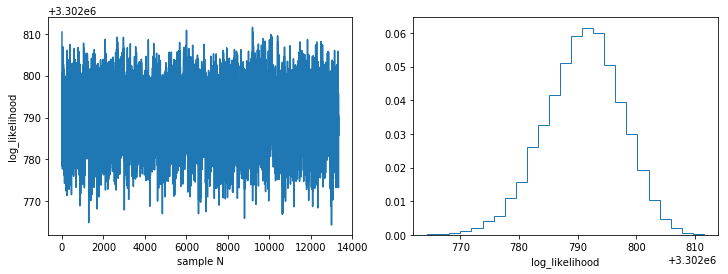

In [15]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(chain_L)
ax1.set_ylabel('log_likelihood')
ax1.set_xlabel('sample N')

ax2 = fig.add_subplot(122)
ax2.hist(chain_L, bins=25, density=True, histtype='step')
ax2.set_xlabel('log_likelihood');

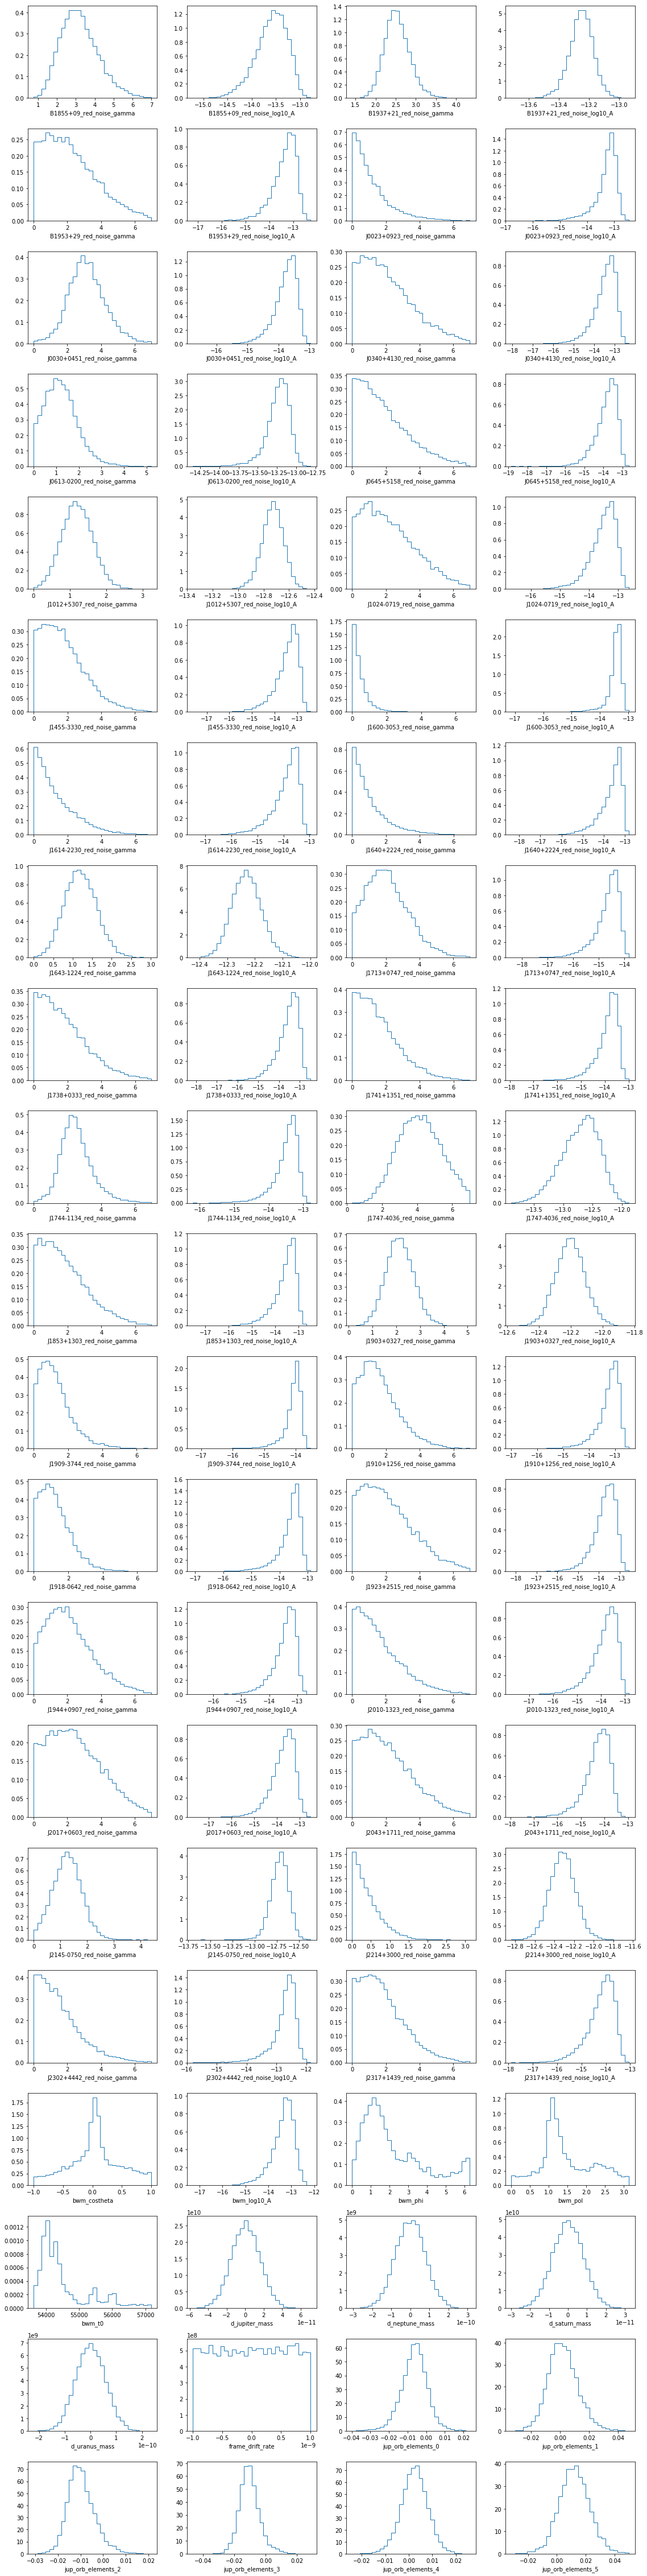

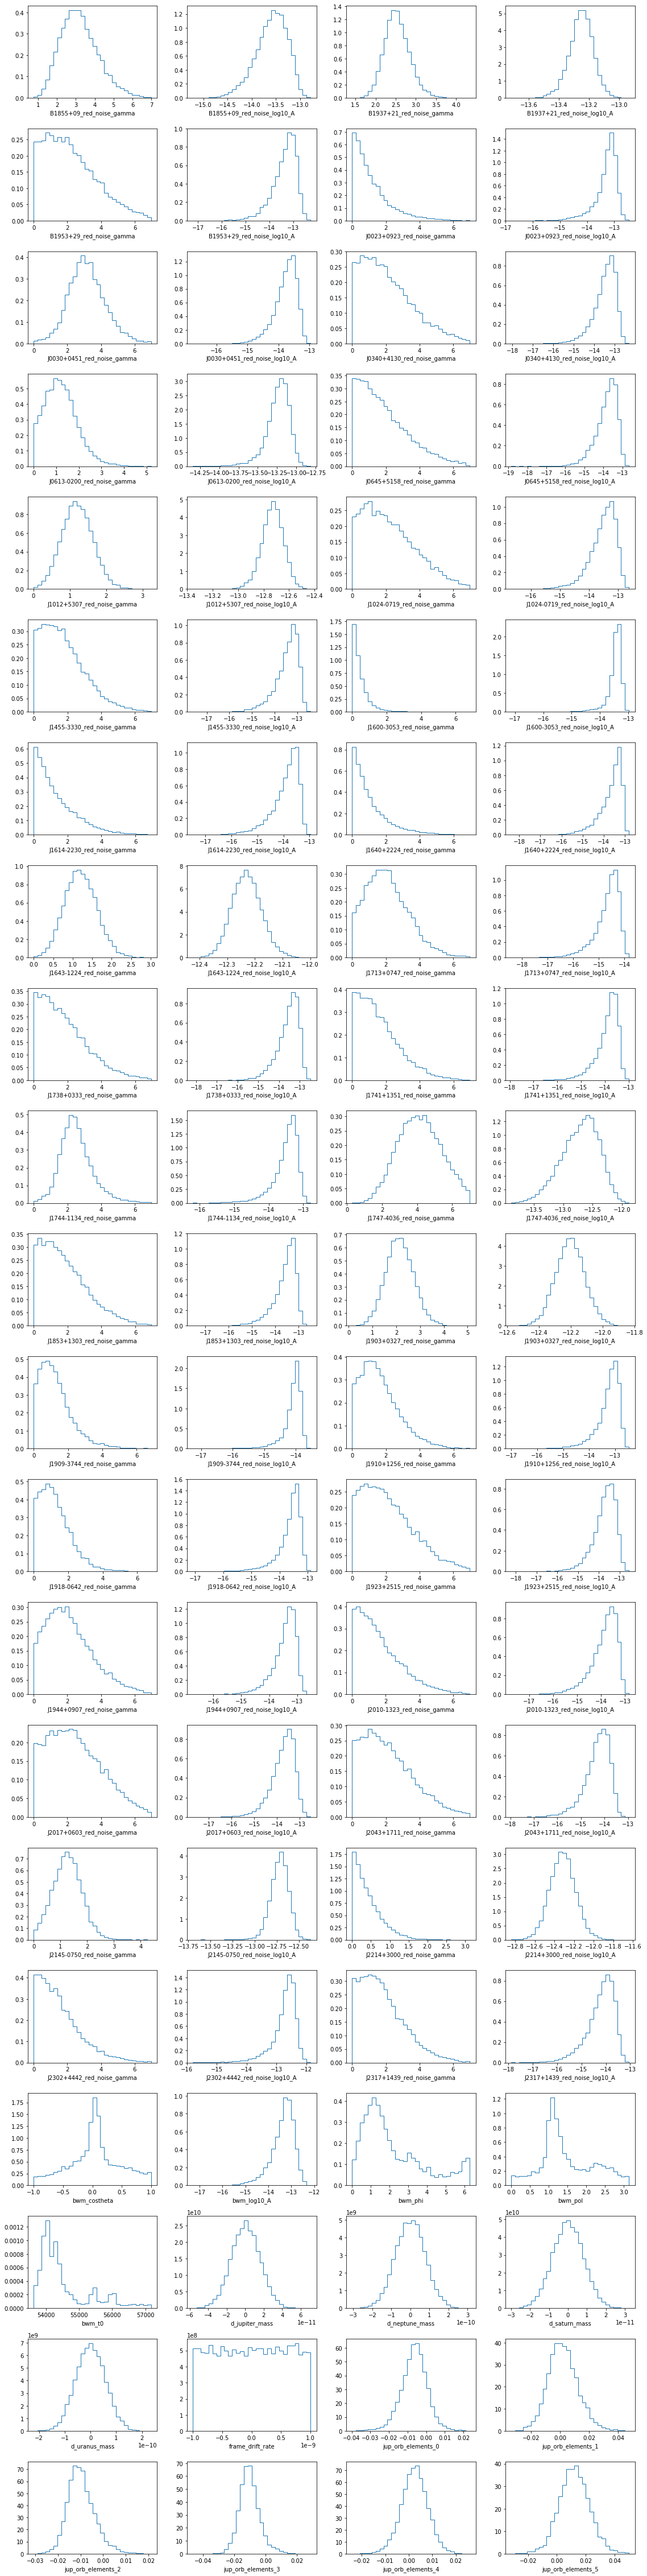

In [16]:
hist_plot(chain[:,:-4], params, cols=4)

## trace plots

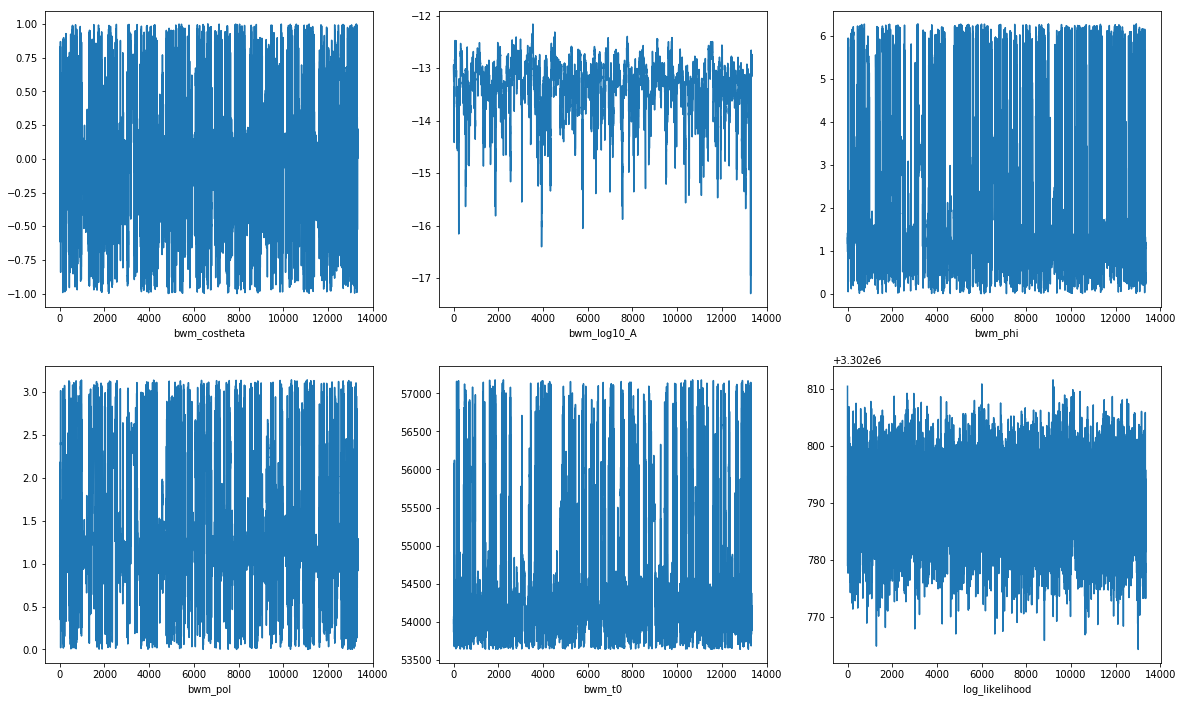

In [20]:
ax = []
fig = plt.figure(figsize=(20,12))

for pp, par in enumerate(par_bwm):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].plot(chain_bwm[:,pp])
    ax[pp].set_xlabel(par)

ax.append(fig.add_subplot(2,3,6))
ax[5].plot(chain[:,-4])
ax[5].set_xlabel('log_likelihood');

## Corner and Histograms

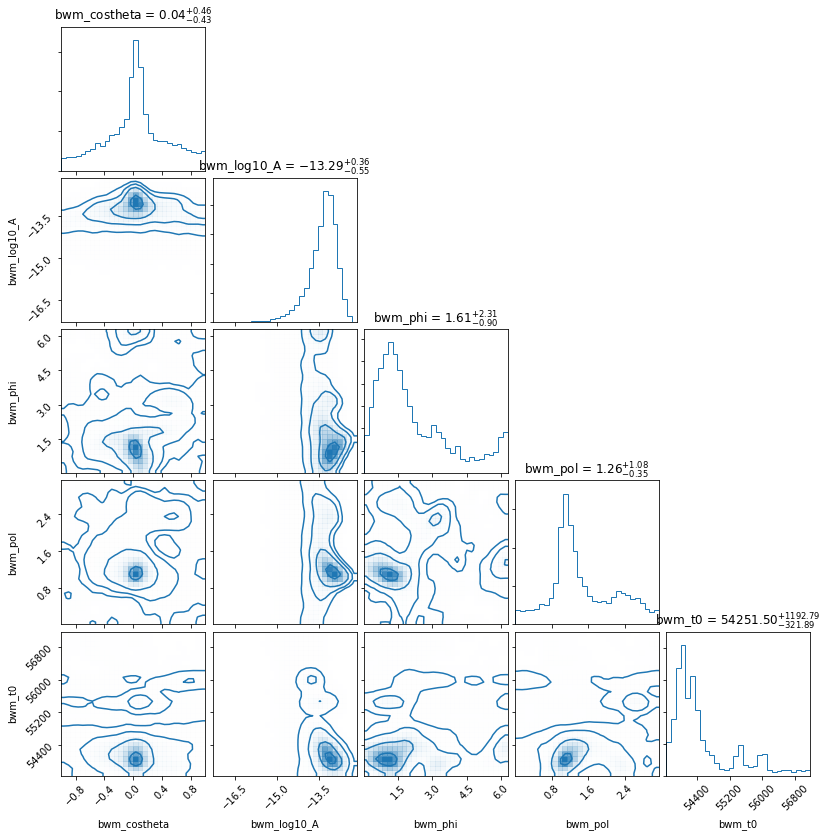

In [21]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':1.0,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

Text(0.5, 0, 'log_likelihood')

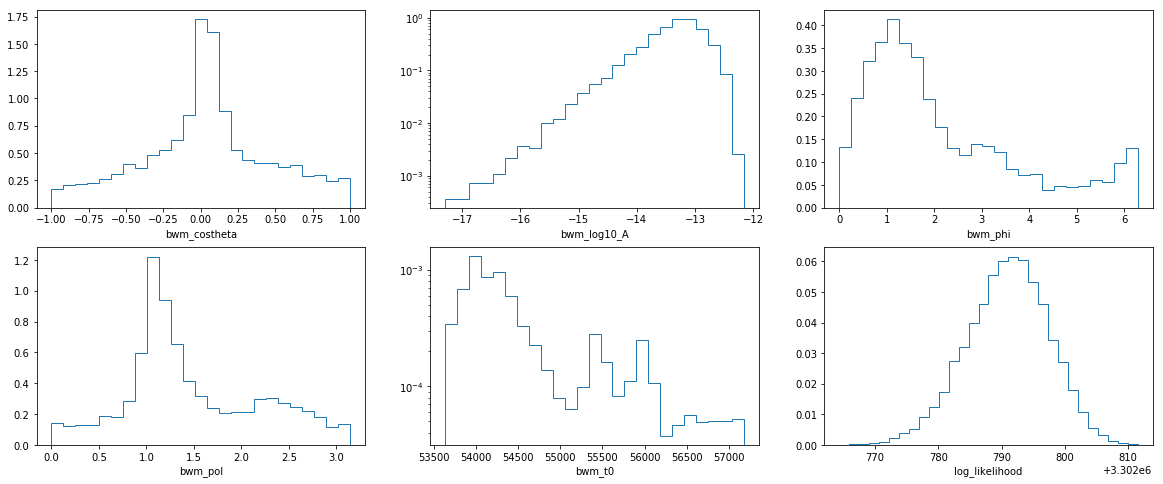

In [22]:
ax = []
fig = plt.figure(figsize=(20,8))

for pp, par in enumerate(par_bwm):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].hist(chain_bwm[:,pp], bins=25, density=True, histtype='step') #, label='')
    ax[pp].set_xlabel(par)

#ax[0].legend(loc='upper left')
ax[idx_A].set_yscale('log')
ax[idx_t0].set_yscale('log')

ax.append(fig.add_subplot(2,3,6))
ax[5].hist(chain[:,-4], bins=30, density=True, histtype='step')
ax[5].set_xlabel('log_likelihood')

(53217.0, 57387.0)

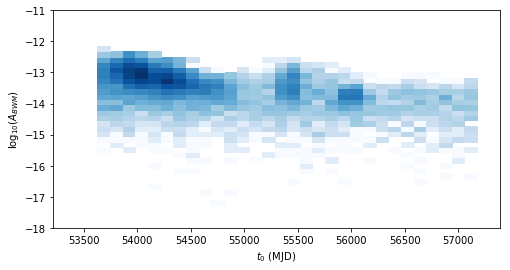

In [23]:
lognorm = LogNorm()

hist_kwargs = {'bins':30,
               'normed':True,
               'cmap':'Blues',
               #'vmin':1.0e5,
               #'vmax':1.0e10,
               'norm':lognorm,
                }

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

t_ch = chain_bwm[:,idx_t0]
logA_ch = chain_bwm[:,idx_A]
A_ch = 10**logA_ch
    
ax.hist2d(t_ch, logA_ch, **hist_kwargs)

if ii_t:
    ax.axvline(x=tmin, color='k', linestyle=':')
    ax.axvline(x=tmax, color='k', linestyle=':')

ax.set_xlabel(r'$t_0$ (MJD)')
ax.set_ylabel(r'$\log_{10}(A_{BWM})$')
ax.set_ylim([-18,-11])
ax.set_xlim([TMIN, TMAX])
#ax.set_title('{:.1f} yr timeslice (w/ dropout)'.format(slice_yr))

/home/pbaker/.local/opt/miniconda/envs/enterprise/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


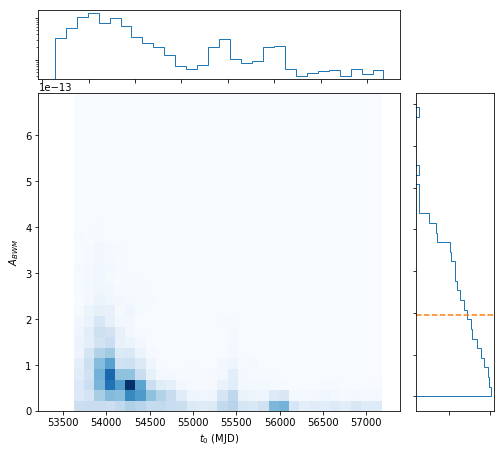

In [24]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter

UL, dUL = UL_uncert(A_ch, p=0.95)

# Define size of figure
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(10, 12)

# Define the positions of the subplots.
ax0 = plt.subplot(gs[6:10, 5:9])
axx = plt.subplot(gs[5:6, 5:9])
axy = plt.subplot(gs[6:10, 9:10])


hist_kwargs = {'bins':30,
               'normed':True,
               'cmap':'Blues',
              }
ax0.hist2d(t_ch, A_ch, **hist_kwargs)
ax0.set_xlabel(r'$t_0$ (MJD)')
ax0.set_ylabel(r'$A_{BWM}$')
ax0.set_xlim([TMIN, TMAX])
#ax0.set_ylim([0, 0.13e-12])

axx.hist(t_ch, 30, normed=True, histtype='step', color='C0')
axx.set_yscale('log')
axy.hist(A_ch, 30, normed=True, histtype='step', color='C0', orientation='horizontal')
axy.axhline(y=UL, color='C1', linestyle='--')
axy.set_xscale('log')
               
# Remove tick labels
nullfmt = NullFormatter()
axx.xaxis.set_major_formatter(nullfmt)
axx.yaxis.set_major_formatter(nullfmt)
axy.xaxis.set_major_formatter(nullfmt)
axy.yaxis.set_major_formatter(nullfmt)

# UL v. t_0

DE436_BE
53300.40: N = 12298, corL = 7.82, corA = 12.18
53383.80: N = 11838, corL = 8.69, corA = 15.22
53467.20: N = 11368, corL = 5.63, corA = 28.21
53550.60: N = 12337, corL = 4.86, corA = 35.07
53634.00: N = 12370, corL = 4.10, corA = 25.54
53717.40: N = 12232, corL = 10.21, corA = 46.11
53800.80: N = 11996, corL = 7.62, corA = 26.87
53884.20: N = 11860, corL = 14.39, corA = 43.23
53967.60: N = 11999, corL = 7.11, corA = 44.49
54051.00: N = 11856, corL = 7.97, corA = 43.96
54134.40: N = 11810, corL = 8.32, corA = 40.75
54217.80: N = 11829, corL = 5.10, corA = 96.54
54301.20: N = 11812, corL = 5.54, corA = 60.91
54384.60: N = 11951, corL = 3.69, corA = 41.99
54468.00: N = 11999, corL = 5.26, corA = 37.22
54551.40: N = 11858, corL = 6.57, corA = 17.24
54634.80: N = 11758, corL = 5.73, corA = 70.14
54718.20: N = 12324, corL = 4.00, corA = 36.31
54801.60: N = 11849, corL = 4.39, corA = 43.72
54885.00: N = 12040, corL = 4.21, corA = 36.02
54968.40: N = 11632, corL = 4.46, corA = 27.54


/home/pbaker/.local/opt/miniconda/envs/enterprise/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


55051.80: N = 11967, corL = 3.64, corA = 21.76
55135.20: N = 12212, corL = 4.51, corA = 30.76
55218.60: N = 12076, corL = 5.53, corA = 89.44
55302.00: N = 11970, corL = 6.55, corA = 41.58
55385.40: N = 11685, corL = 6.29, corA = 63.40
55468.80: N = 11569, corL = 9.16, corA = 39.18
55552.20: N = 11826, corL = 7.62, corA = 24.21
55635.60: N = 11919, corL = 3.86, corA = 58.15
55719.00: N = 12087, corL = 5.39, corA = 32.94
55802.40: N = 11861, corL = 3.99, corA = 31.88
55885.80: N = 11727, corL = 6.09, corA = 22.38
55969.20: N = 11329, corL = 4.68, corA = 65.16
56052.60: N = 11668, corL = 5.40, corA = 37.37
56136.00: N = 11647, corL = 4.66, corA = 29.98
56219.40: N = 11676, corL = 3.24, corA = 22.14
56302.80: N = 11700, corL = 3.28, corA = 28.74
56386.20: N = 11715, corL = 5.90, corA = 35.72
56469.60: N = 11683, corL = 6.73, corA = 27.73
56553.00: N = 11720, corL = 4.09, corA = 28.45
56636.40: N = 11843, corL = 4.40, corA = 28.18
56719.80: N = 12057, corL = 3.60, corA = 54.80
56803.20: N =

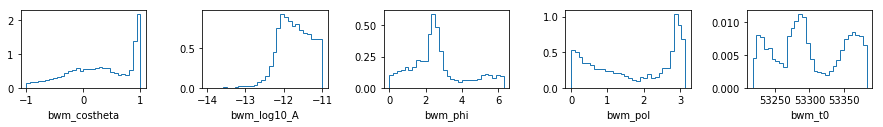

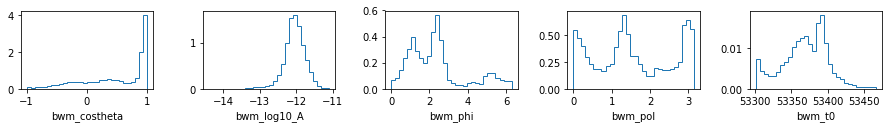

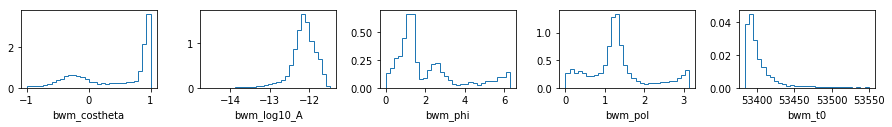

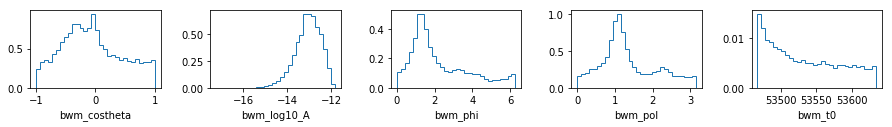

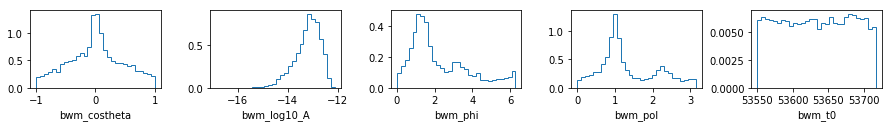

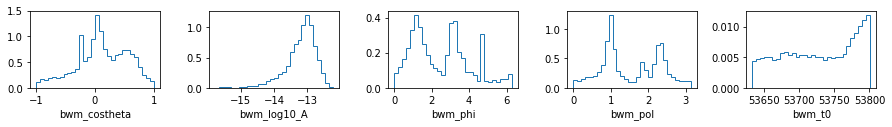

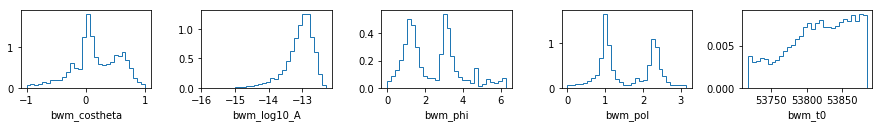

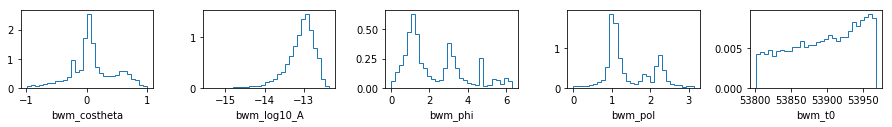

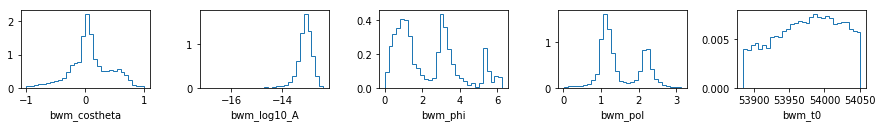

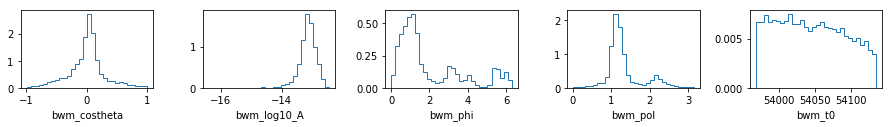

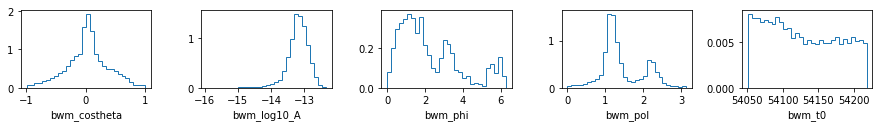

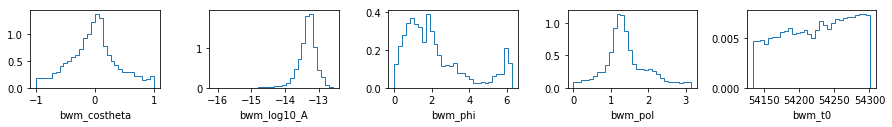

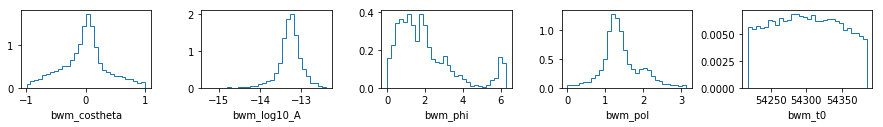

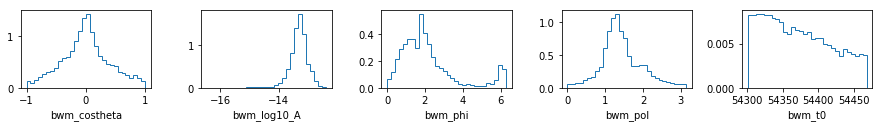

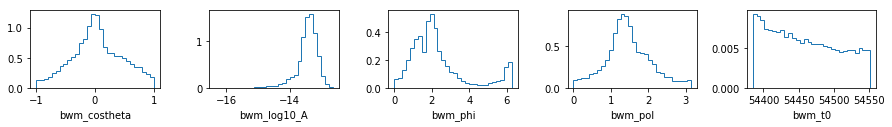

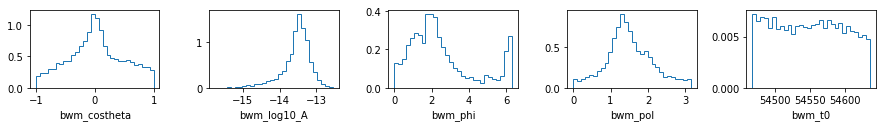

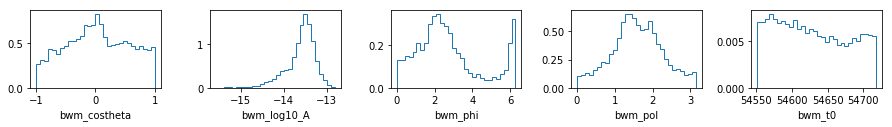

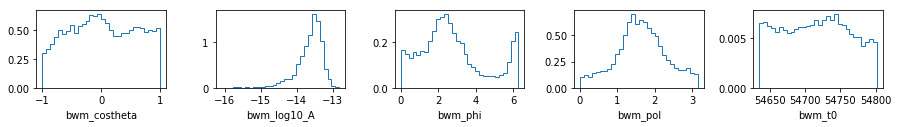

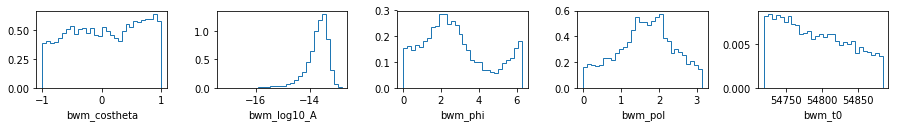

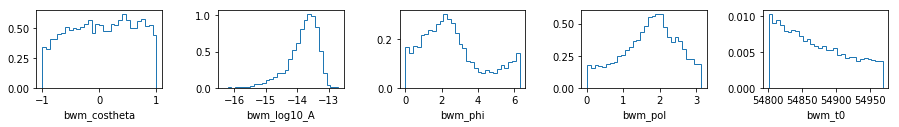

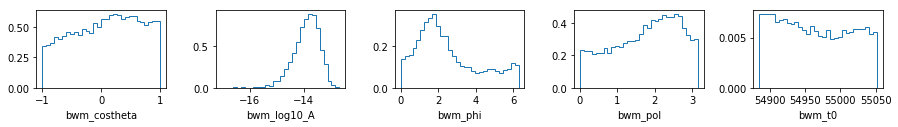

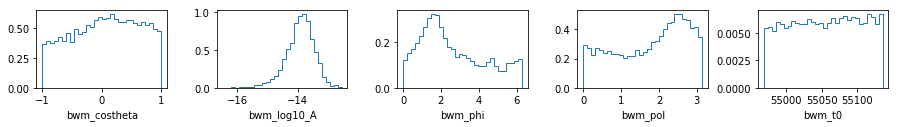

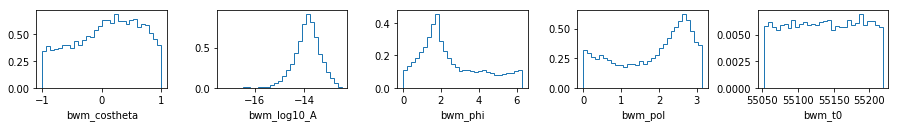

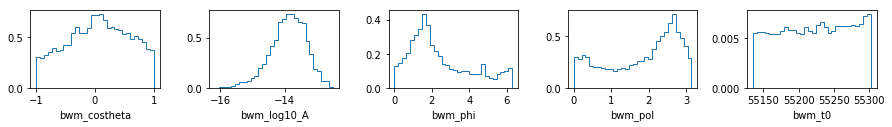

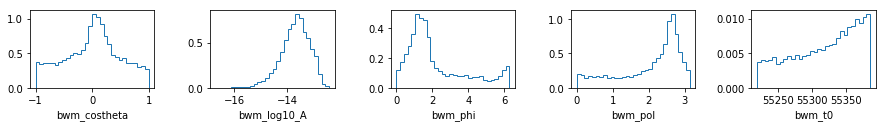

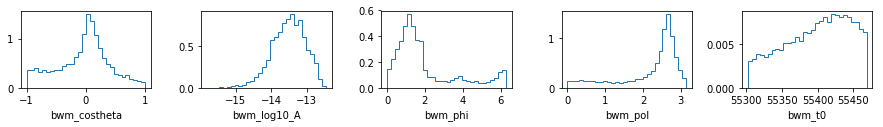

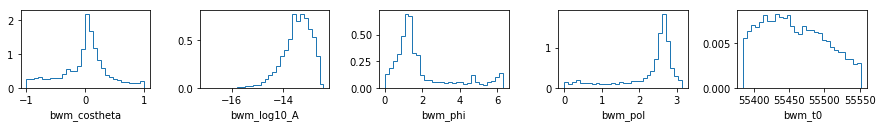

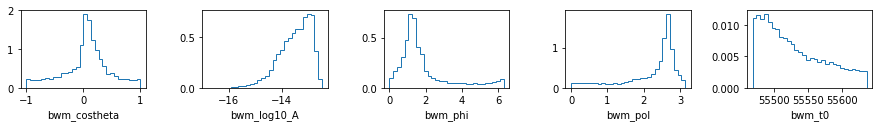

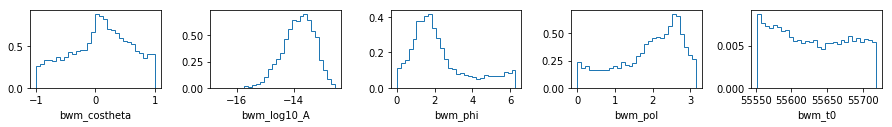

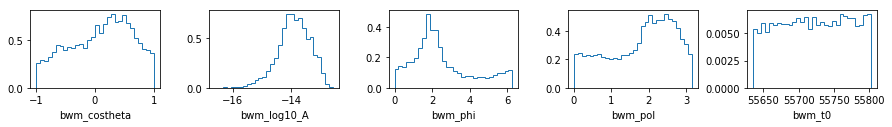

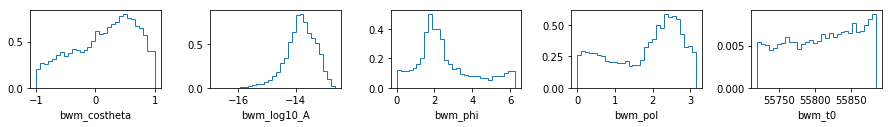

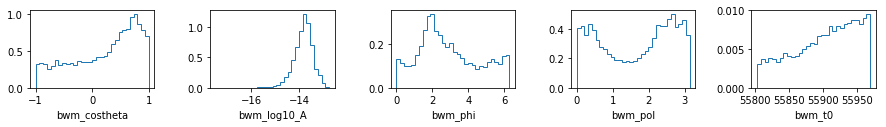

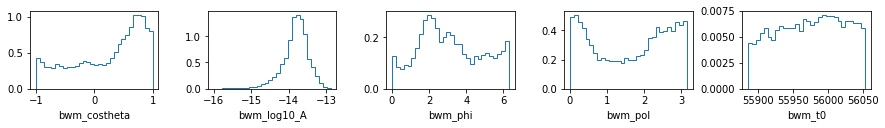

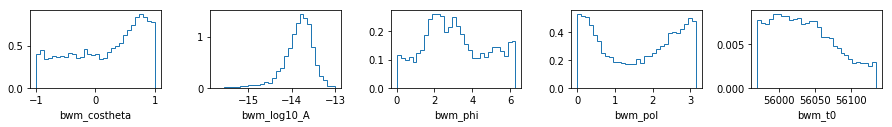

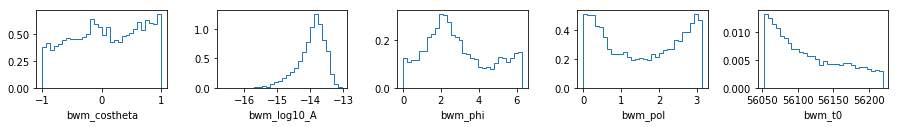

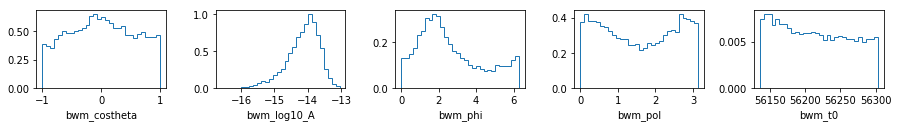

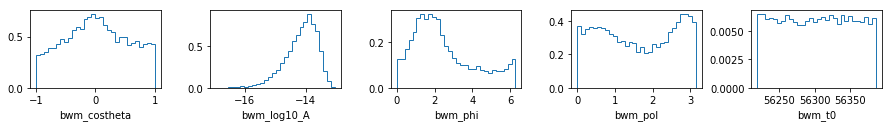

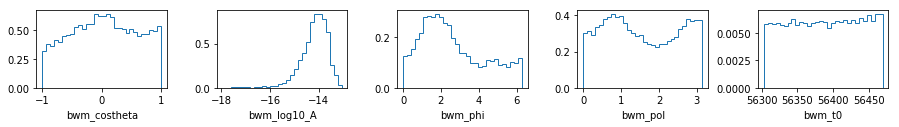

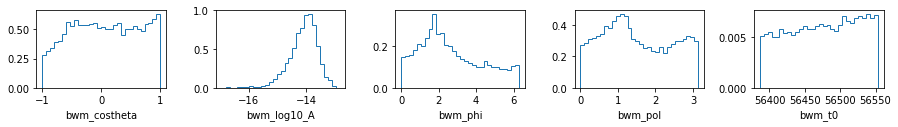

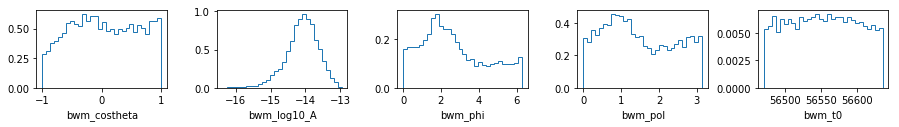

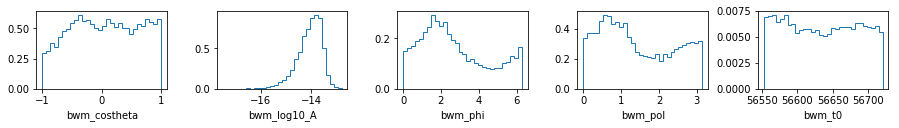

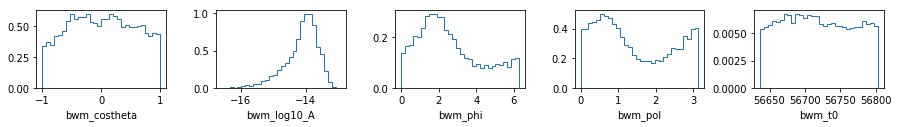

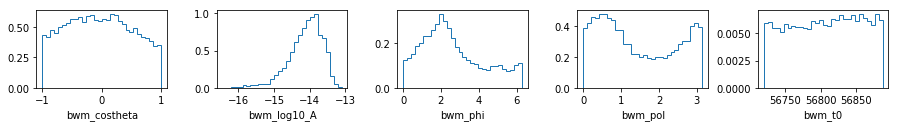

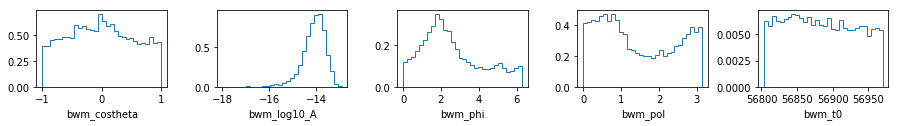

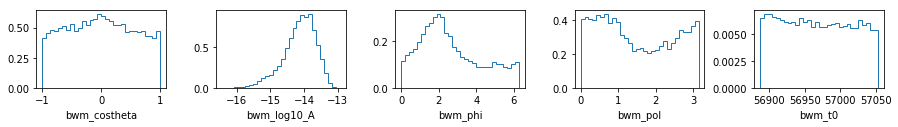

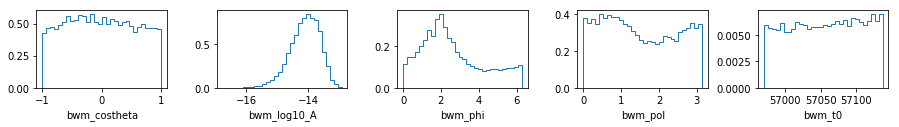

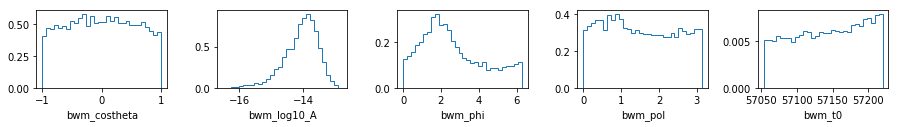

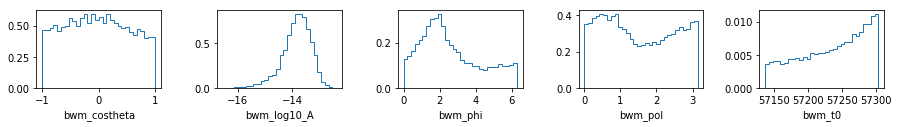

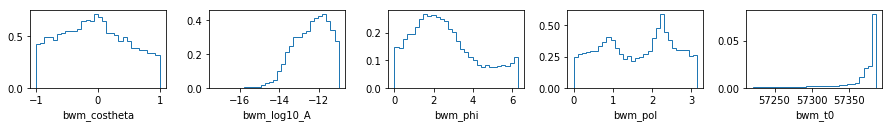

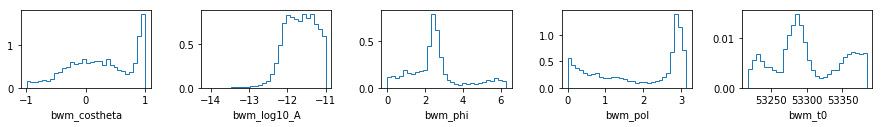

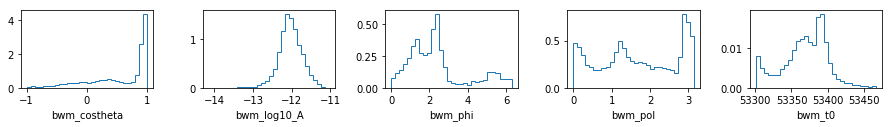

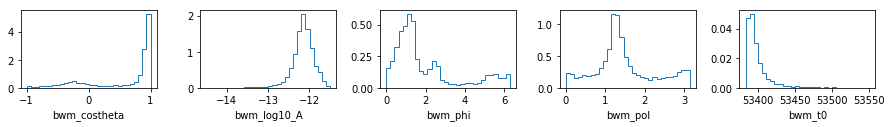

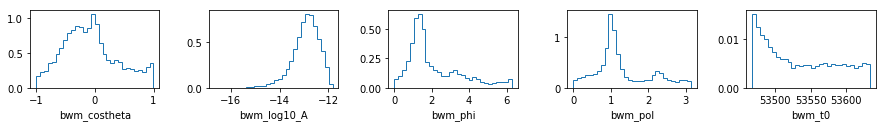

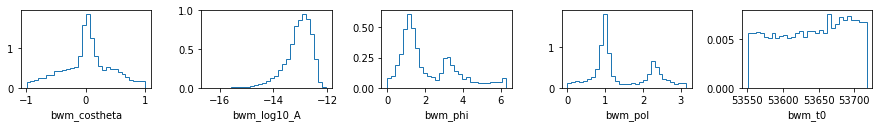

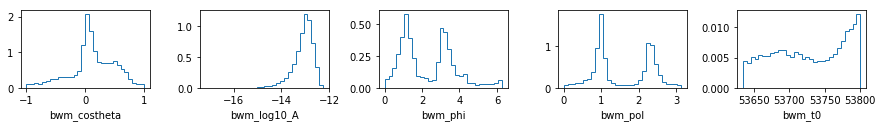

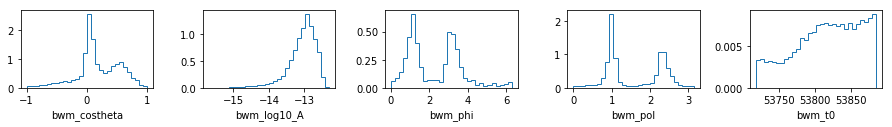

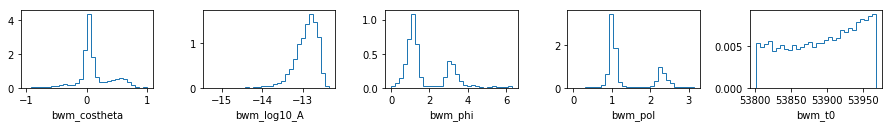

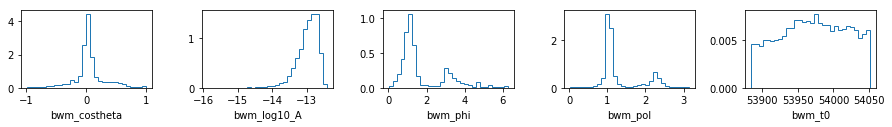

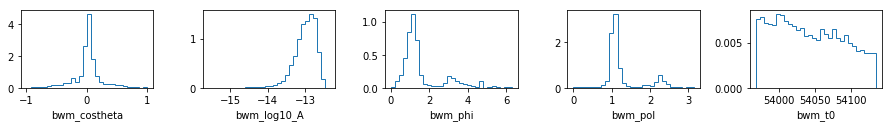

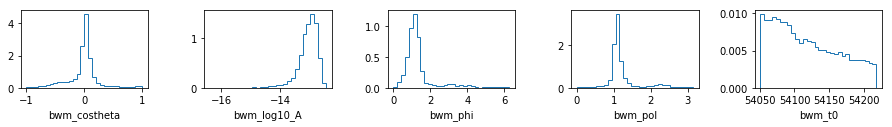

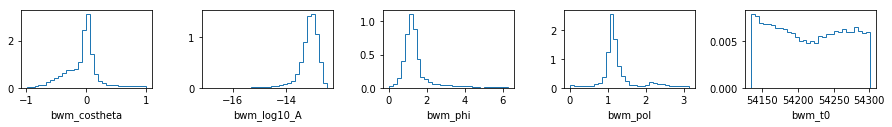

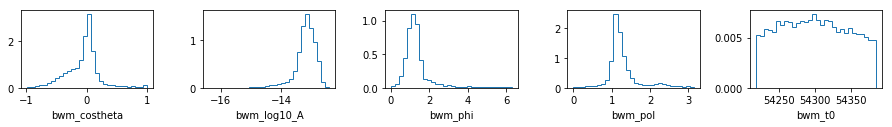

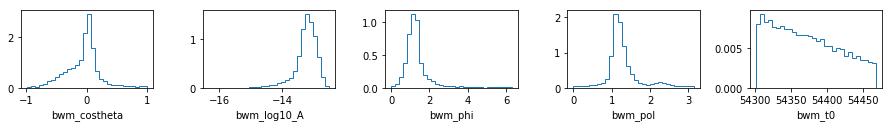

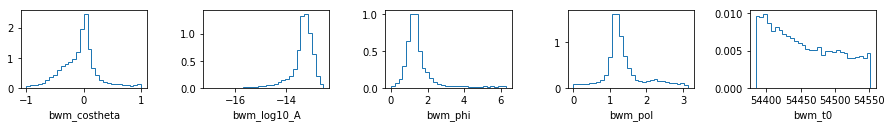

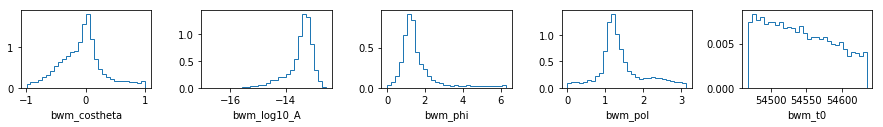

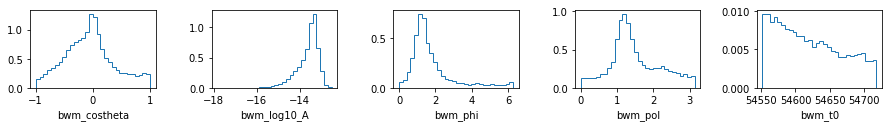

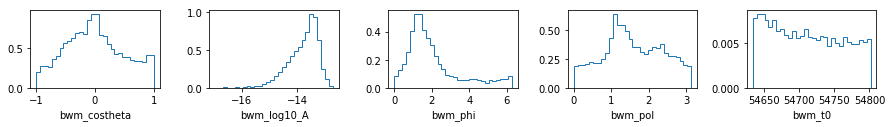

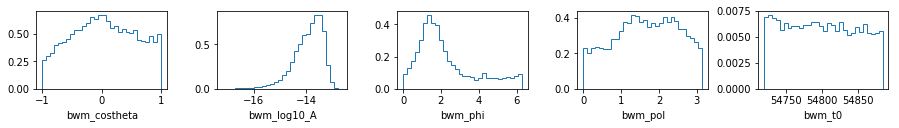

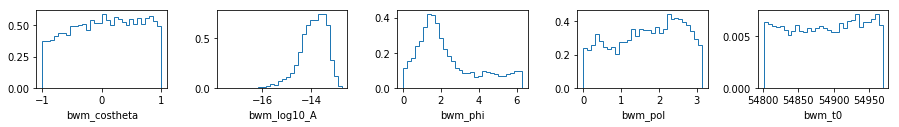

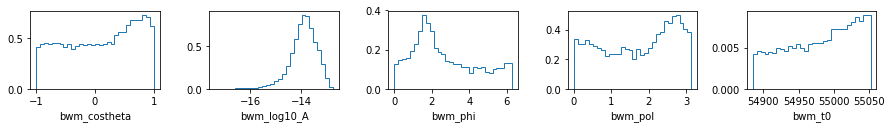

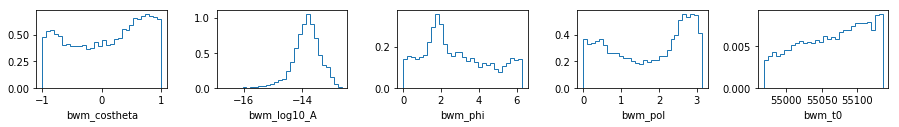

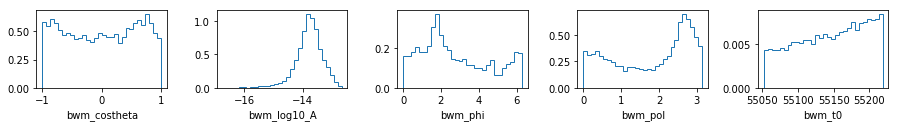

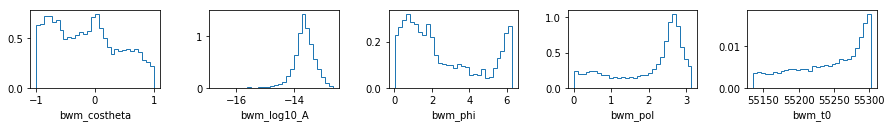

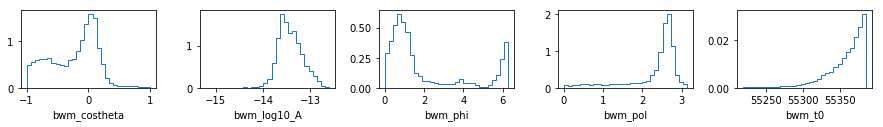

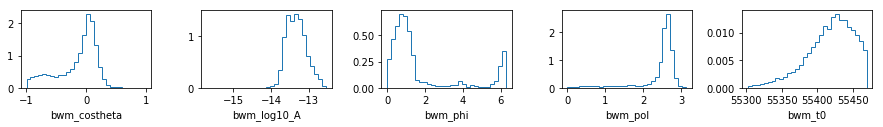

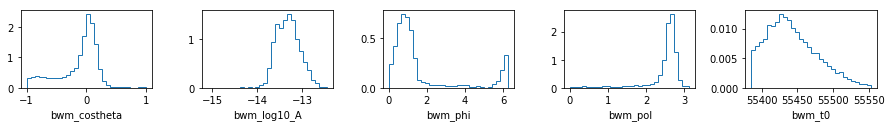

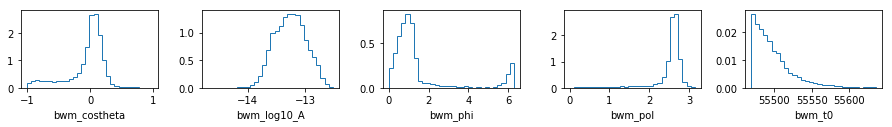

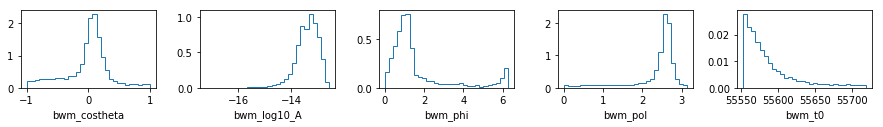

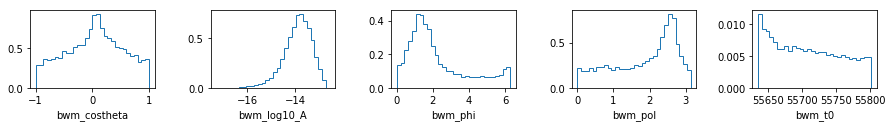

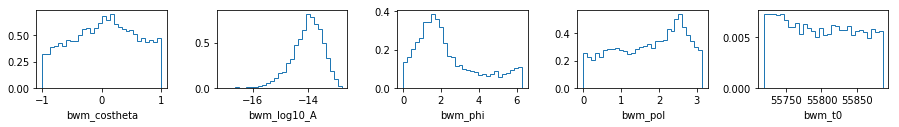

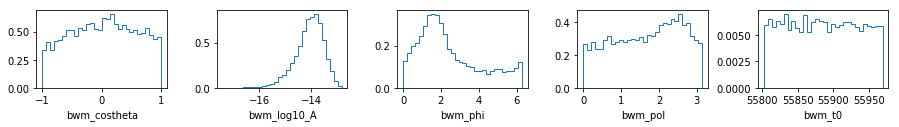

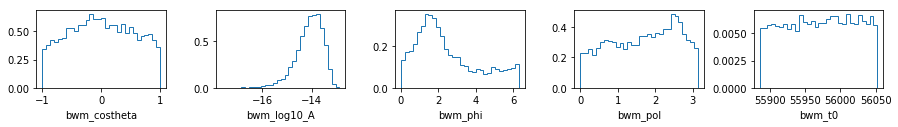

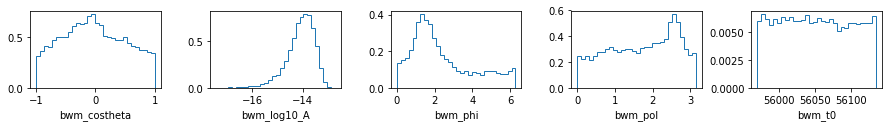

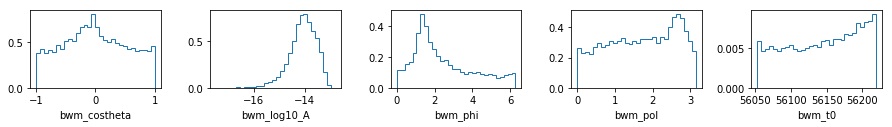

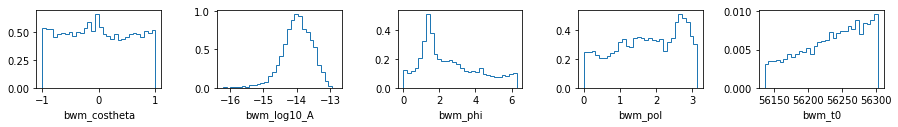

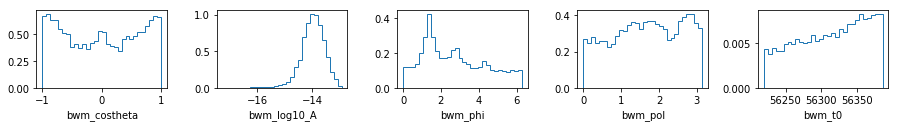

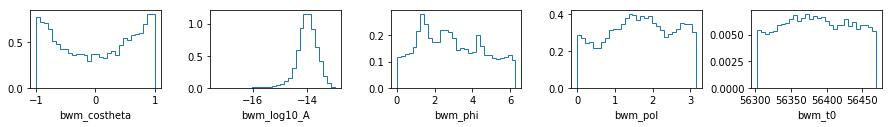

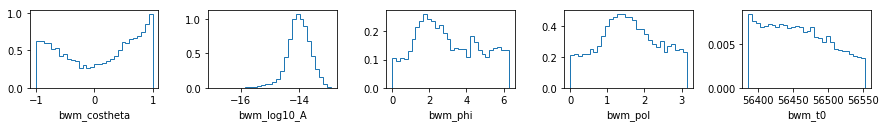

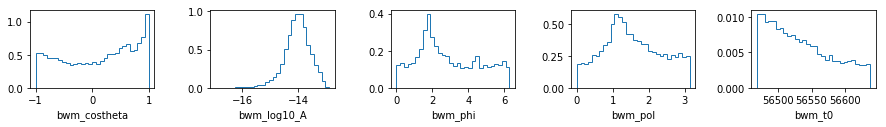

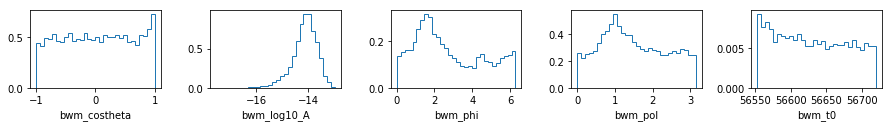

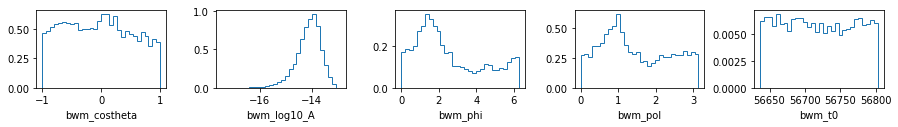

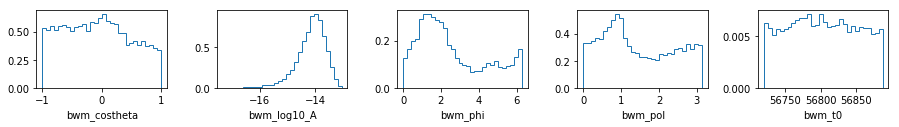

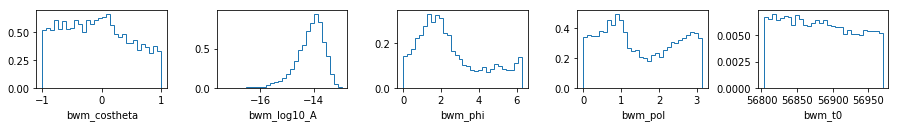

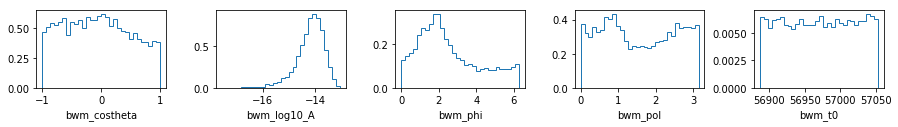

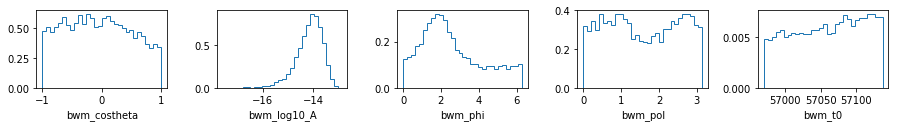

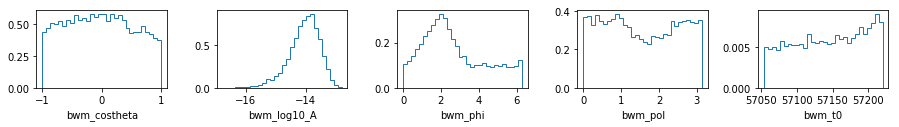

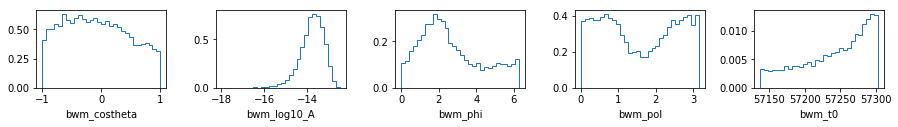

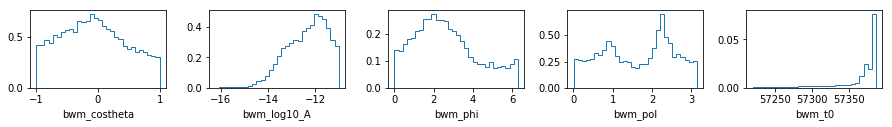

In [41]:
burnfrac = 0.15
thin = 50

#ephems = ['DE421', 'DE430', 'DE436']
ephems = ['DE436']
bayeseph_flags = [True, False]

#ephems = ['DE421']
#bayeseph_flags = [False]
figs = []

ULs = {}
dULs = {}

for ephem in ephems:
    for bayesephem in bayeseph_flags:
        BE = '_BE' if bayesephem else ''
        key = ephem+BE
        print(key)
        ULs[key] = []
        dULs[key] = []

        for ts in tlim:
            tmin, cent, tmax = ts
            chunk = '{:.2f}'.format(cent)
            rundir = '/home/pbaker/nanograv/bwm/allsky_rerun/{0:s}/{1:s}/'.format(key, chunk)
            chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                                    sep='\t', dtype=float, header=None).values
            burn = int(burnfrac * len(chain_raw))
            chain = chain_raw[burn::thin]
            chain_bwm = chain[:,idx_bwm]  # no ephem model
            chain_L = chain[:,-4]

            corL = acor(chain_L)[0]
            corA = acor(chain_bwm[:,idx_A])[0]
            N = len(chain_bwm)
            print("{:.2f}: N = {:d}, corL = {:.2f}, corA = {:.2f}".format(cent, N, corL, corA))
    
            this_UL, this_dUL = UL_subsamp(10**chain_bwm[:,idx_A], p=0.95)
            ULs[key].append(this_UL)
            dULs[key].append(this_dUL)
            
            figs.append(hist_plot(chain_bwm, par_bwm, cols=5, wid_per_col=2.5))

print('DONE!')

In [42]:
from astropy.time import Time

Ts = np.array(tlim)[:,1]

Ts = Time(Ts, format='mjd').decimalyear

In [43]:
savedir = './ULvT_rerun/'

!mkdir -p $savedir

cols = [k for k in ULs.keys()]
ULvt = np.vstack([u for u in ULs.values()])
dULvt = np.vstack([u for u in dULs.values()])

np.savetxt(savedir + '11yr_cols.dat', cols, fmt=b'%s')
np.savetxt(savedir + '11yr_UL.dat', ULvt)
np.savetxt(savedir + '11yr_dUL.dat', dULvt)
np.savetxt(savedir + '11yr_Ts.dat', Ts)

In [44]:
# save per chunk hists
outdir = "hists_"+key
!mkdir -p $outdir

for ii,fig in enumerate(figs):
    fig.savefig("hists_"+key+"/hist_{:02d}.png".format(ii))
    plt.close(fig)

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,
        'ytick.major.size':6,
        'ytick.minor.size':3,
        'xtick.major.width':0.7,
        'ytick.major.width':0.7,
        'xtick.minor.width':0.7,
        'ytick.minor.width':0.7,
        'lines.markeredgewidth':1.2,
        'axes.linewidth':1.375,
        'legend.fontsize': 7,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'savefig.dpi':200,
        'path.simplify':True,
        #'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble':'\\usepackage{amsmath}',
        'text.usetex':True,
         }

plt.rcParams.update(params)

In [45]:
from astropy.time import Time

Ts = np.array(tlim)[:,1]

Ts = Time(Ts, format='mjd').decimalyear

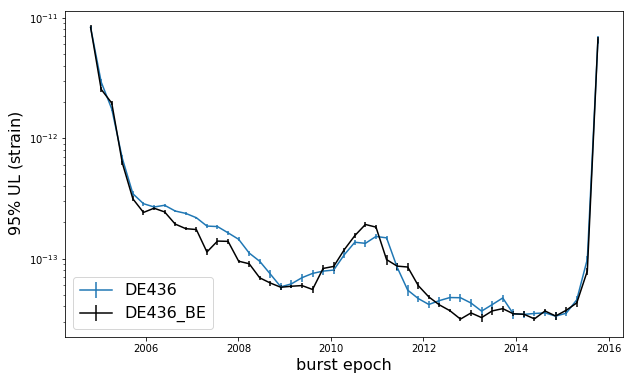

In [46]:
plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#ax.errorbar(Ts, ULs['DE421'], yerr=dULs['DE421'], color='C0', label='DE421')
#ax.errorbar(Ts, ULs['DE430'], yerr=dULs['DE430'], color='C1', label='DE430')
ax.errorbar(Ts, ULs['DE436'], yerr=dULs['DE436'], color='C0', label='DE436')

#ax.errorbar(Ts, ULs['DE421_BE'], yerr=dULs['DE421_BE'], color='C0', label='DE421')
#ax.errorbar(Ts, ULs['DE430_BE'], yerr=dULs['DE430_BE'], color='C1', label='DE430')
ax.errorbar(Ts, ULs['DE436_BE'], yerr=dULs['DE436_BE'], color='k', label='DE436_BE')

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

fig.savefig('/home/pbaker/11yr_ULvt.pdf')
plt.show()

Text(0, 0.5, '$95\\%$ UL (strain)')

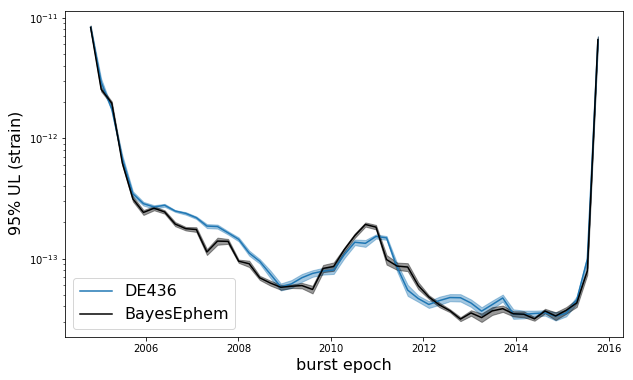

In [47]:
high = np.array(ULs['DE436']) + np.array(dULs['DE436'])
low = np.array(ULs['DE436']) - np.array(dULs['DE436'])

high_BE = np.array(ULs['DE436_BE']) + np.array(dULs['DE436_BE'])
low_BE = np.array(ULs['DE436_BE']) - np.array(dULs['DE436_BE'])

plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.fill_between(Ts, low, high, color='C0', alpha=0.4)
ax.plot(Ts, ULs['DE436'], color='C0', label='DE436')

ax.fill_between(Ts, low_BE, high_BE, color='k', alpha=0.4)
ax.plot(Ts, ULs['DE436_BE'], color='k', label='BayesEphem')


ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

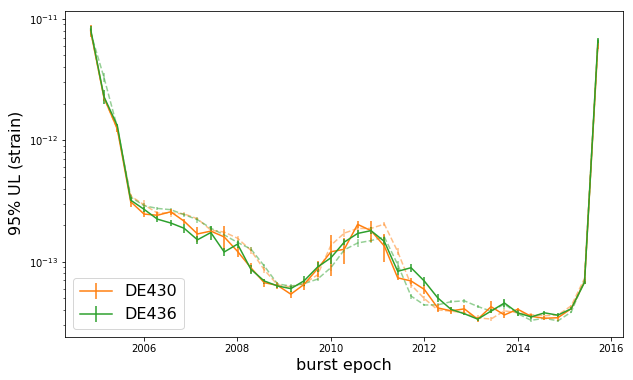

In [16]:
plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#ax.errorbar(Ts, ULs['DE421'], yerr=dULs['DE421'], color='C0', alpha=0.5, ls='--')
ax.errorbar(Ts, ULs['DE430'], yerr=dULs['DE430'], color='C1', alpha=0.5, ls='--')
ax.errorbar(Ts, ULs['DE436'], yerr=dULs['DE436'], color='C2', alpha=0.5, ls='--')

#ax.errorbar(Ts, ULs['DE421_BE'], yerr=dULs['DE421_BE'], color='C0', label='DE421')
ax.errorbar(Ts, ULs['DE430_BE'], yerr=dULs['DE430_BE'], color='C1', label='DE430')
ax.errorbar(Ts, ULs['DE436_BE'], yerr=dULs['DE436_BE'], color='C2', label='DE436')

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

fig.savefig('/home/pbaker/11yr_ULvt_BE.pdf')
plt.show()

In [ ]:
plt.close('all')

ephem = 'DE436'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.errorbar(Ts, ULs[ephem], yerr=dULs[ephem], color='C0', alpha=0.5, ls='--')
ax.errorbar(Ts, ULs[ephem+'_BE'], yerr=dULs[ephem+'_BE'], color='C0', label=ephem)

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

#fig.savefig('/home/pbaker/11yr_ULvt_compare.pdf')
plt.show()

In [ ]:
plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(Ts, ULs['DE421'], color='C0', alpha=0.5, ls='--')
ax.plot(Ts, ULs['DE430'], color='C1', alpha=0.5, ls='--')
ax.plot(Ts, ULs['DE436'], color='C2', alpha=0.5, ls='--')

ax.plot(Ts, ULs['DE421_BE'], color='C0', label='DE421')
ax.plot(Ts, ULs['DE430_BE'], color='C1', label='DE430')
ax.plot(Ts, ULs['DE436_BE'], color='C2', label='DE436')

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

#fig.savefig('/home/pbaker/11yr_ULvt_BE.pdf')
plt.show()

# Rate Upper Limit

In [61]:
from scipy.integrate import simps

_GMsun = 1.32712440018e20  # m^3/s^2
_c = 299792458 # m/s
_Rsun = _GMsun / _c**2 # meters
_pc = 3.0857e16 # meters

M = 1e10 * _Rsun / (1e9*_pc) # Gpc
Erad = 0.07*M  # energy radiated

# h = 69/(8*24) Erad/r

hUL = np.array(ULs['DE436_BE'])

r_sens = 69/(8*24) * Erad / hUL
V_sens = 4/3*np.pi * r_sens**3

rateUL = simps(y=V_sens, x=Ts) # /Gpc^3 /yr

In [62]:
69/(8*24) * 0.07 *_Rsun

37.14634861848667

In [63]:
rateUL

0.46927444794486362

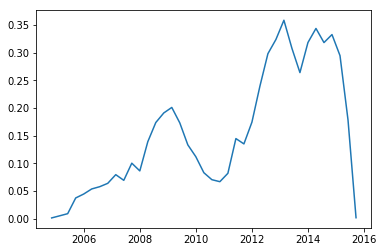

In [64]:
plt.plot(Ts, r_sens)

In [90]:
dT = np.mean(np.diff(Ts))
hsort = np.sort(hUL)
Ns = np.arange(len(hsort))+1

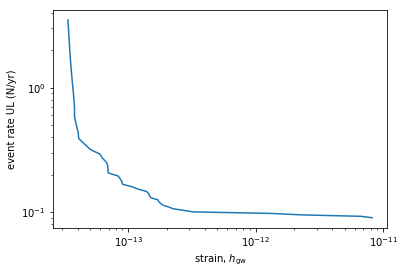

In [102]:
plt.plot(hsort, 1/(Ns*dT))
plt.xlabel('strain, $h_\mathrm{gw}$')
plt.ylabel('event rate UL (N/yr)')
plt.xscale('log')
#plt.xlim([1e-21, 1e-11])
#plt.ylim([0, 1.75])
plt.yscale('log')

In [103]:
cols = [k for k in ULs.keys()]
ULvt = np.vstack([u for u in ULs.values()])
dULvt = np.vstack([u for u in dULs.values()])

np.savetxt('./ULvT/11yr_cols.dat', cols, fmt=b'%s')
np.savetxt('./ULvT/11yr_UL.dat', ULvt)
np.savetxt('./ULvT/11yr_dUL.dat', dULvt)
np.savetxt('./ULvT/11yr_Ts.dat', Ts)

In [100]:
cols

[u'DE436', u'DE430_BE', u'DE430', u'DE421_BE', u'DE421', u'DE436_BE']

In [ ]:
Tobs = TMAX-TMIN

0.1*Tobs / 365.25

In [37]:
for tt, uu in zip(np.array(tlim)[:,1], ULs['DE436_BE']):
    print("{:.2f}:    h_mem < {:.3e}".format(tt, uu))

53300.40:    h_mem < 8.298e-12
53383.80:    h_mem < 2.542e-12
53467.20:    h_mem < 1.954e-12
53550.60:    h_mem < 6.211e-13
53634.00:    h_mem < 3.129e-13
53717.40:    h_mem < 2.415e-13
53800.80:    h_mem < 2.619e-13
53884.20:    h_mem < 2.438e-13
53967.60:    h_mem < 1.933e-13
54051.00:    h_mem < 1.771e-13
54134.40:    h_mem < 1.742e-13
54217.80:    h_mem < 1.134e-13
54301.20:    h_mem < 1.397e-13
54384.60:    h_mem < 1.389e-13
54468.00:    h_mem < 9.507e-14
54551.40:    h_mem < 9.052e-14
54634.80:    h_mem < 6.918e-14
54718.20:    h_mem < 6.266e-14
54801.60:    h_mem < 5.775e-14
54885.00:    h_mem < 5.890e-14
54968.40:    h_mem < 5.966e-14
55051.80:    h_mem < 5.538e-14
55135.20:    h_mem < 8.279e-14
55218.60:    h_mem < 8.603e-14
55302.00:    h_mem < 1.185e-13
55385.40:    h_mem < 1.551e-13
55468.80:    h_mem < 1.919e-13
55552.20:    h_mem < 1.824e-13
55635.60:    h_mem < 9.805e-14
55719.00:    h_mem < 8.656e-14
55802.40:    h_mem < 8.506e-14
55885.80:    h_mem < 5.962e-14
55969.20

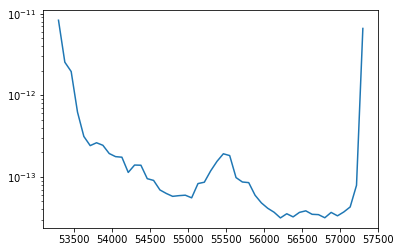

In [40]:
plt.plot(np.array(tlim)[:,1], ULs['DE436_BE'], color='C0', label='DE436')
plt.yscale('log')